In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.utils import MixtureNormalSampler
from entot.models.gen_model import OTFlowMatching, MLP_FM_VAE2, Bridge_MLP
from entot.plotting.plots import plot_1D_balanced_new

2023-07-26 05:55:45.935550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


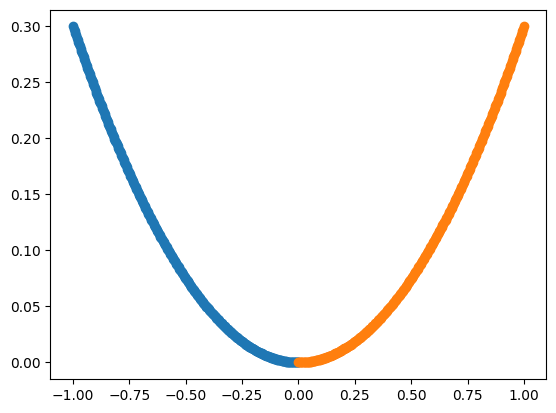

In [17]:
x0 = np.linspace(-1, 0, 300)
y0 = np.cos(x0) * 5 / + 0.1 * np.random.randn(len(x0))
data0 = np.concatenate((x0[:,None], y0[:,None]), axis=1)

x1 = np.linspace(0, 1, 300)
y1 = np.cos(x1) * 5 + 0.1 * np.random.randn(len(x1))
data1 = np.concatenate((x1[:,None], y1[:,None]), axis=1)

x0 = np.linspace(-1, 0, 300)
x1 = np.linspace(0, 1, 300)

y0 = 0.3 * (x0**2)
y1 = 0.3 * (x1**2)

source = np.concatenate((x0[:,None], y0[:,None]), axis=1)
target = np.concatenate((x1[:,None], y1[:,None]), axis=1)

plt.scatter(source[:,0], source[:,1])
plt.scatter(target[:,0], target[:,1])

In [18]:
neural_net = MLP_FM_VAE2(2, 128, 128, 128, n_frequencies=10)
bridge_net = Bridge_MLP(2, 64, 64)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solver_latent_to_data = ott.solvers.linear.sinkhorn.Sinkhorn()
graph_kwargs = {"k_neighbors": 512}
otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=2, output_dim=2, iterations=10_000, k_noise_per_x=10, solver_latent_to_data=solver_latent_to_data, graph_kwargs=graph_kwargs)

In [83]:
otfm(source, target, 512, 512)

 87%|████████▋ | 8708/10000 [15:05<02:14,  9.61it/s]


KeyboardInterrupt: 

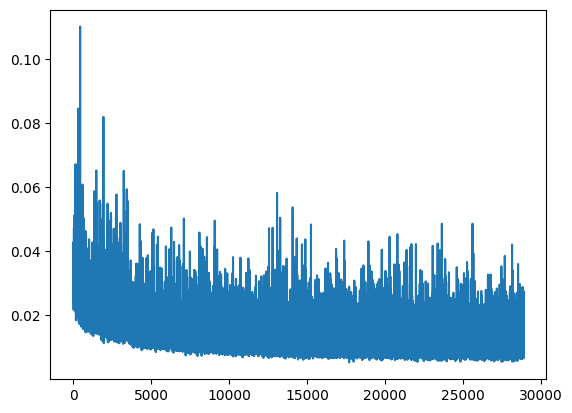

In [84]:
plt.plot(np.arange(len(otfm.metrics["loss"][500:])), otfm.metrics["loss"][500:])

In [85]:
res, _, _ = otfm.transport(source, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})
pushed_source = res[0,...]

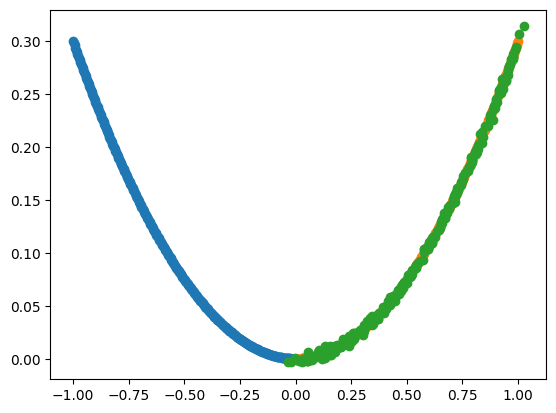

In [86]:
plt.scatter(source[:,0], source[:,1])
plt.scatter(target[:,0], target[:,1])
plt.scatter(pushed_source[:,0], pushed_source[:,1])

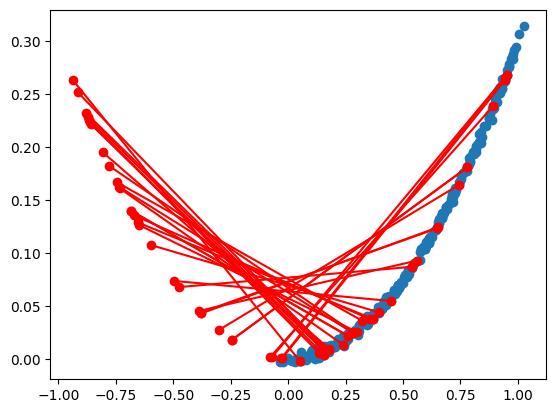

In [87]:
plt.scatter(pushed_source[:,0], pushed_source[:,1])
indices = jax.random.randint(jax.random.PRNGKey(1), (30,), 0, len(data0))

plt.plot([source[indices, 0], pushed_source[indices, 0]],[source[indices, 1],pushed_source[indices, 1]] ,'ro-')
plt.show()


In [88]:
pushed_source_0, _, _ = otfm.transport(source, seed=0, diffeqsolve_kwargs={"max_steps": 1_000_000})
pushed_source_1, _, _ = otfm.transport(source, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})
pushed_source_2, _, _ = otfm.transport(source, seed=2, diffeqsolve_kwargs={"max_steps": 1_000_000})


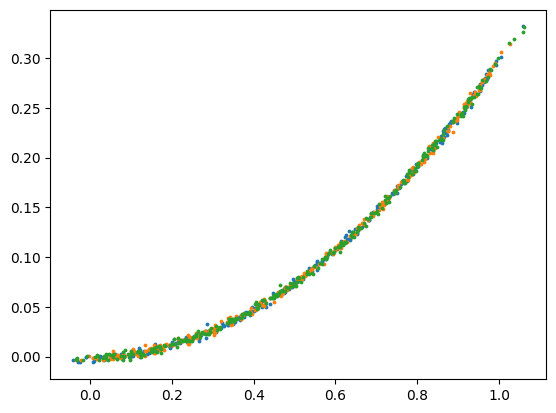

In [89]:
plt.scatter(pushed_source_0[0,:,0], pushed_source_0[0,:,1], s=3)
plt.scatter(pushed_source_1[0,:,0], pushed_source_1[0,:,1], s=3)
plt.scatter(pushed_source_2[0,:,0], pushed_source_2[0,:,1], s=3)

In [90]:
pushed = jnp.concatenate((pushed_source_0, pushed_source_1, pushed_source_2))

In [91]:
indices = jax.random.randint(jax.random.PRNGKey(1), (5,), 0, len(source))
source_x = jnp.repeat(source[indices, 0], 3)
pushed_source_x = pushed[:,indices,0].flatten(order='F')
source_y = jnp.repeat(source[indices, 1], 3)
pushed_source_y = pushed[:,indices,1].flatten(order='F')

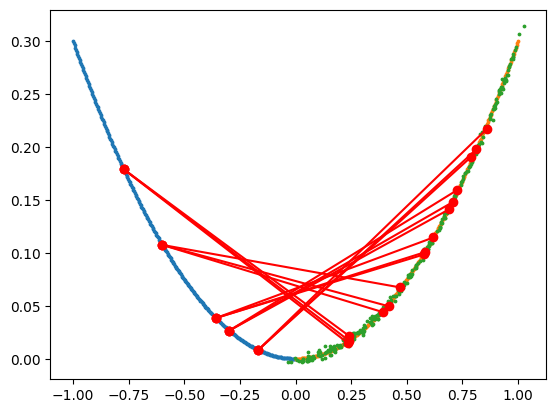

In [92]:
plt.scatter(source[:,0], source[:,1], s=3)
plt.scatter(target[:,0], target[:,1], s=3)
plt.scatter(pushed_source[:,0], pushed_source[:,1], s=3)
plt.plot([source_x, pushed_source_x],[source_y,pushed_source_y] ,'ro-')
plt.show()